## MO444 Project 3 - Reinforcement Learning

* Rodrigo Araújo Marinho Franco - RA: 233569
* Felipe Marinho Tavares - RA: 265680

### Contributions:
* Rodrigo
 * ...
* Felipe
 * ...

# PART I - Evolutionary Model

# PART II - Reinforcement Learning

In [1]:
from collections import deque
import matplotlib.pyplot as plt

import environment

Linear layer input size:  640
Linear layer input size:  640
Initial state:


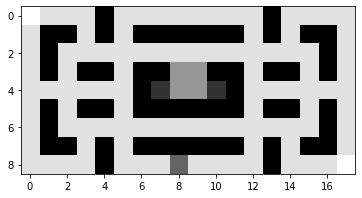

Shape:  (9, 18, 1)
Episode:  100 Average Score: 3.05 Winrate: 0.00%
Episode:  200 Average Score: 3.77 Winrate: 0.00%
Episode:  300 Average Score: 9.54 Winrate: 0.00%
Episode:  400 Average Score: 16.18 Winrate: 0.00%
Episode:  500 Average Score: 25.92 Winrate: 0.00%
Episode:  600 Average Score: 50.30 Winrate: 0.00%
Episode:  700 Average Score: 61.91 Winrate: 0.00%
Episode:  800 Average Score: 51.48 Winrate: 0.00%
Episode:  900 Average Score: 46.12 Winrate: 0.00%
Episode:  1000 Average Score: 45.62 Winrate: 0.00%
Episode:  1100 Average Score: 51.86 Winrate: 0.00%
Episode:  1200 Average Score: 58.81 Winrate: 0.00%
Episode:  1300 Average Score: 66.25 Winrate: 0.00%
Episode:  1400 Average Score: 57.84 Winrate: 0.00%
Episode:  1500 Average Score: 48.76 Winrate: 0.00%
Episode:  1600 Average Score: 61.26 Winrate: 0.00%


In [ ]:
wins = []
wins_window = deque(maxlen=200)
scores = []
scores_window = deque(maxlen=200)
average_scores = []



env = environment.Environment(learning_rate=1e-5)


eps_start = 1.0
eps_end = 0.05
eps_decay=0.999
eps = eps_start

n_episodes = 3000
print_every = n_episodes/30
for i_episode in range(1, n_episodes + 1):
    env.reset()

    while not env.done():
        env.step(eps)

    eps = max(eps_end, eps_decay*eps)

    scores.append(env.game.state.getScore())
    scores_window.append(env.game.state.getScore())

    wins.append(env.game.state.isWin())
    wins_window.append(env.game.state.isWin())

    average_score = sum(scores_window)/float(len(scores_window))
    winrate = sum(wins_window)/float(len(wins_window)) * 100.0
    average_scores.append(average_score)

    if i_episode % print_every == 0:
        print("Episode: ", i_episode, end=" ")
        print('Average Score: {:.2f}'.format(average_score), end=" ")
        print('Winrate: {:.2f}%'.format(winrate))

plt.figure(figsize=(10, 5))
plt.title("Scores during training")
line1, = plt.plot(scores)
line2, = plt.plot(average_scores)
plt.legend([line1, line2], ["Score", "Average Score"])
plt.show()